In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima import auto_arima
import pickle  
from prophet import Prophet


DATA COLLECTION

Datos de Yahoo Finance

In [12]:
sp500 = yf.Ticker("^GSPC")
gold = yf.Ticker("^GC=F")
oil= yf.Ticker("CL=F")
brent= yf.Ticker("BZ=F")

Datos de FRED (Banco de la Reserva Federal de St. Louis)

In [ ]:
import requests


# FRED API endpoint
url = "https://api.stlouisfed.org/fred/series/observations"

# List of series IDs to be downloaded
# CREDIT RISK AND RISK APPETITE VARIABLES
# DAAA = Moody's Seasoned Aaa Corporate Bond Yield
# AAA10Y = Moody's Seasoned Aaa Corporate Bond Yield Relative to Yield on 10-Year Treasury Constant Maturity
# DBAA = Moody's Seasoned Baa Corporate Bond Yield
# BAA10Y = Moody's Seasoned Baa Corporate Bond Yield Relative to Yield on 10-Year Treasury Constant Maturity
# BAMLH0A0HYM2 = ICE BofA US High Yield Index Option-Adjusted Spread 
# BAMLH0A2HYB = ICE BofA Single-B US High Yield Index Option-Adjusted Spread 
# BAMLH0A3HYC = ICE BofA CCC & Lower US High Yield Index Option-Adjusted Spread
# BAMLHE00EHYIOAS = ICE BofA Euro High Yield Index Option-Adjusted Spread -  

# INTEREST RATE VARIABLES
# T10Y2Y = 10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant Maturity
# T10Y3M = 10-Year Treasury Constant Maturity Minus 3-Month Treasury Constant Maturity  
# T5YIE = 5-Year Breakeven Inflation Rate (Expected Inflation Rate) - 5-Year 

# EXCHANGE RATES Vs main commercial partners for the U.S.
# DEXUSEU = U.S. Dollars to Euro Spot Exchange Rate - value of one U.S. Dollar in Euros
# DEXCHUS = Chinese Yuan Renminbi to U.S. Dollar Spot Exchange Rate - value of one Chinese Yuan Renminbi in U.S. Dollars
# DEXCAUS = Canadian Dollars to U.S. Dollar Spot Exchange Rate - value of one Canadian Dollar in U.S. Dollars
# DEXMXUS= Mexican Pesos to U.S. Dollar Spot Exchange Rate - value of one Mexican Peso in U.S. Dollars

# VOLATILITY INDECES (MARKET EXPECTATION OF NEAR TERM VOLATILITY)
# VIXCLS = CBOE Volatility Index - VIX measures market expectation of near term volatility conveyed by stock index option prices.

series_ids = ['DAAA','AAA10Y','DBAA','BAA10Y','BAMLH0A0HYM2','BAMLH0A2HYB','BAMLH0A3HYC','BAMLHE00EHYIOAS','T10Y2Y','T10Y3M','T5YIE','DEXUSEU','DEXCHUS','DEXCAUS','DEXMXUS','VIXCLS']

# Your FRED API key
api_key = '7de04d83472c6affd4e0a1505211d3b9'

# Initialize an empty dictionary to store DataFrames
dfs = {}

# Loop through each series ID
for series_id in series_ids:
    # API parameters
    params = {
        'series_id': series_id,
        'api_key': api_key,
        'file_type': 'json',
    }
    
    # Make the API request
    response = requests.get(url, params=params)
    
    # Check if the request was successful
    if response.status_code == 200:
        # Convert the response to JSON
        data = response.json()
        # Extract data for DataFrame
        dates = [item['date'] for item in data['observations']]
        values = [item['value'] for item in data['observations']]
        # Create DataFrame and convert types
        temp_df = pd.DataFrame({'Date': dates, series_id: values})
        temp_df['Date'] = pd.to_datetime(temp_df['Date'])
        temp_df[series_id] = pd.to_numeric(temp_df[series_id], errors='coerce')
        # Add the DataFrame to the dictionary
        dfs[series_id] = temp_df.set_index('Date')
    else:
        print(f"Failed to retrieve data for {series_id}: {response.status_code}")

# Combine all the series DataFrames into one DataFrame 
macroeconomic_df = pd.concat(dfs.values(), axis=1)




### Análisis de la serie de tiempo AUTO ARIMA

DATA CLEANING AND ORGANIZING

In [13]:
sp500 = sp500.history(period="max")
sp500.index= sp500.index.tz_localize(None)
sp500.head ()


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0


<Axes: xlabel='Date'>

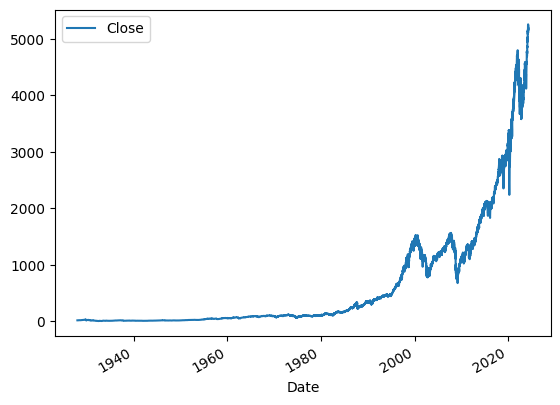

In [14]:
#Se eliminan las columnas que no se van a utilizar
# Crear un nuevo DataFrame seleccionando solo las columnas 'Date' y 'Close'
sp500_ARIMA = sp500.iloc[:, [3]]
sp500_ARIMA.plot(y="Close", use_index=True)

<Axes: xlabel='Date'>

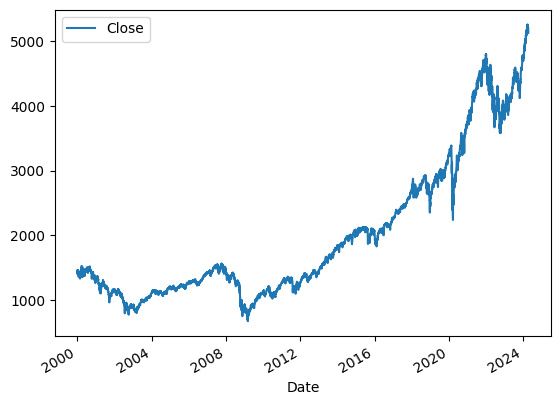

In [15]:
# Se delimita el rango de fechas  para que incluya solo los datos a partir del año 2000 
sp500_ARIMA =sp500_ARIMA.loc['2000-01-01':].copy ()
sp500_ARIMA.plot(y="Close", use_index=True)

In [16]:
#Verificar si hay valores nulos
missing_values = sp500_ARIMA.isnull().sum()
print(missing_values)

Close    0
dtype: int64


In [17]:
#Guardar el dataset en un archivo csv   
sp500_ARIMA.to_csv('sp500_yahoo2000.csv', index=True)

In [18]:
# Se convierte el índice a tipo datetime
sp500_ARIMA.index = pd.to_datetime(sp500_ARIMA.index)
# Asegurar que el índice esté en formato de fecha y ordenado
sp500_ARIMA.sort_index(inplace=True)


ANÁLISIS DE LA SERIE HISTORICA

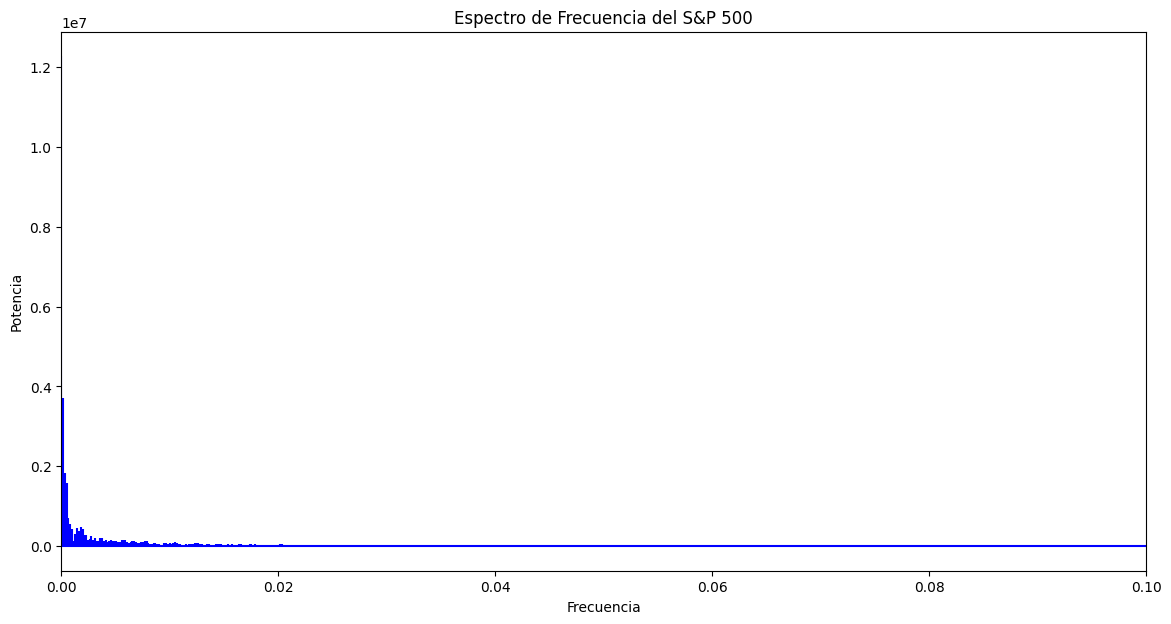

In [19]:

#Análisis de Fourier para determinar si existe estacionalidad
# Asumiendo que sp500_ARIMA es tu DataFrame y 'Close' es la columna con los precios de cierre
datos_sp500 = sp500_ARIMA['Close'].values

# Aplicar la Transformada de Fourier a los datos
fft_result = np.fft.fft(datos_sp500)

# Obtener las frecuencias asociadas
frecuencias = np.fft.fftfreq(datos_sp500.size, d=1)  # Ajusta 'd' según tu frecuencia de datos

# Calcular la potencia de la señal (magnitud del FFT)
potencia = np.abs(fft_result)

# Visualizar el Espectro de Frecuencia
plt.figure(figsize=(14, 7))
plt.stem(frecuencias, potencia, 'b', markerfmt=" ", basefmt="-b")
plt.xlim(0, 0.1)  # Ajusta este rango para enfocarte en las frecuencias bajas y ver mejor los picos
plt.title('Espectro de Frecuencia del S&P 500')
plt.xlabel('Frecuencia')
plt.ylabel('Potencia')
plt.show()


Pico dominante cerca de la frecuencia cero: Este pico grande e inmediato sugiere una fuerte tendencia general en los datos, lo que es esperado en datos financieros debido a la tendencia a largo plazo del mercado (como el crecimiento general del S&P 500 a lo largo de los años).

Disminución rápida en la potencia a medida que aumenta la frecuencia: Después del pico inicial, parece haber una caída muy pronunciada en la potencia a medida que te mueves hacia la derecha en el gráfico, lo que significa que no hay otras frecuencias con una magnitud significativa que contribuyan a la serie temporal. Esto indica que no hay otros ciclos periódicos fuertes y claros aparte de la tendencia general.

Potencia relativamente baja para las frecuencias mayores a cero: No parece haber picos significativos más allá del inicial, lo cual sugiere que no hay estacionalidades fuertes y claras a lo largo del año (como trimestrales o mensuales) que sean consistentemente prominentes en los datos del S&P 500. La serie temporal puede contener ruido o movimientos más aleatorios y menos predecibles que no están ligados a un ciclo estacional específico.

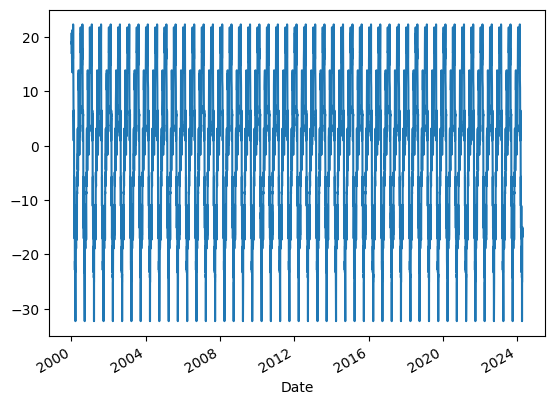

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose


# Assuming sp500['Close'] is your time series data
result = seasonal_decompose(sp500_ARIMA['Close'], model='additive', period=126)

# Plotting the seasonal component
result.seasonal.plot()
plt.show()

# Saving the seasonal component to a CSV file
seasonality_data = pd.DataFrame(result.seasonal)
seasonality_data.to_csv('seasonality_data.csv', index=True)


Este gráfico muestra una serie temporal que parece tener picos y valles regulares a lo largo del tiempo, lo que sugiere una estacionalidad en los datos. Aquí están algunas interpretaciones y consideraciones clave:

Patrones regulares: La consistencia de los picos y valles sugiere un patrón que se repite. En los datos financieros, esto podría ser una señal de estacionalidad en los retornos, donde los picos pueden representar tiempos de retornos sistemáticamente más altos y los valles representar tiempos de retornos más bajos.

Frecuencia de los picos y valles: La distancia entre picos consecutivos (o valles) podría darte la longitud del ciclo estacional. Por ejemplo, si la distancia es aproximadamente de 12 meses, podrías estar viendo estacionalidad anual.

Amplitud de la estacionalidad: La diferencia entre los máximos de los picos y los mínimos de los valles indica la magnitud de la estacionalidad. En este gráfico, parece que hay variaciones significativas que podrían tener implicaciones importantes para la estrategia de trading o inversión.

Tendencia a lo largo del tiempo: Si la amplitud de la estacionalidad se mantiene constante a lo largo del tiempo, eso sugiere una estacionalidad muy estable. Si la amplitud crece o disminuye con el tiempo, esto puede indicar que los factores estacionales están cambiando.

Anomalías: Si hay años en los que los picos o valles son inusualmente altos o bajos, esto podría indicar que eventos específicos afectaron los retornos más de lo habitual.

El gráfico no muestra un claro patrón de aumento o disminución en la amplitud de la estacionalidad a lo largo del tiempo, lo que puede indicar que la fuerza de la estacionalidad no ha cambiado significativamente durante el período observado. Esto es útil para los inversores que confían en patrones estacionales para tomar decisiones.

Para entender completamente qué está impulsando estos patrones, podrías correlacionar los puntos de inflexión con eventos del mercado o económicos específicos, y considerar realizar análisis adicionales para comprender mejor las causas subyacentes de estos patrones.

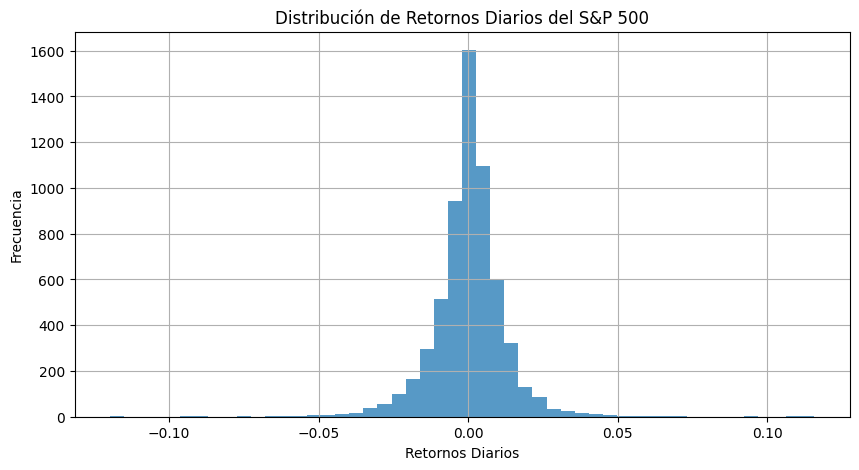

In [21]:

# Calcular los retornos diarios (porcentaje de cambio en el precio de cierre)
sp500_ARIMA['Daily Returns'] = sp500_ARIMA['Close'].pct_change()

# Crear el histograma de los retornos diarios
plt.figure(figsize=[10,5])
plt.hist(sp500_ARIMA['Daily Returns'].dropna(), bins=50, alpha=0.75)
plt.title('Distribución de Retornos Diarios del S&P 500')
plt.xlabel('Retornos Diarios')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

In [ ]:
#Este histograma indica que los retornos diarios del S&P 500 siguen una distribución normal y que la mayoría de los retornos diarios están cerca de cero, es decir, que son pequeños. 
#El patrón cumple con lo que se conoce como market noise donde las fluctuaciones del dia a dia no son significativas.

La mayoría de los retornos diarios parecen agruparse alrededor del centro del histograma, cerca de cero, lo cual es típico para los retornos de índices de mercado en periodos cortos.
La distribución parece ser más o menos simétrica alrededor del pico central, lo que sugiere que los días con ganancias y pérdidas son, en promedio, igualmente comunes y que no hay un sesgo significativo hacia retornos positivos o negativos.

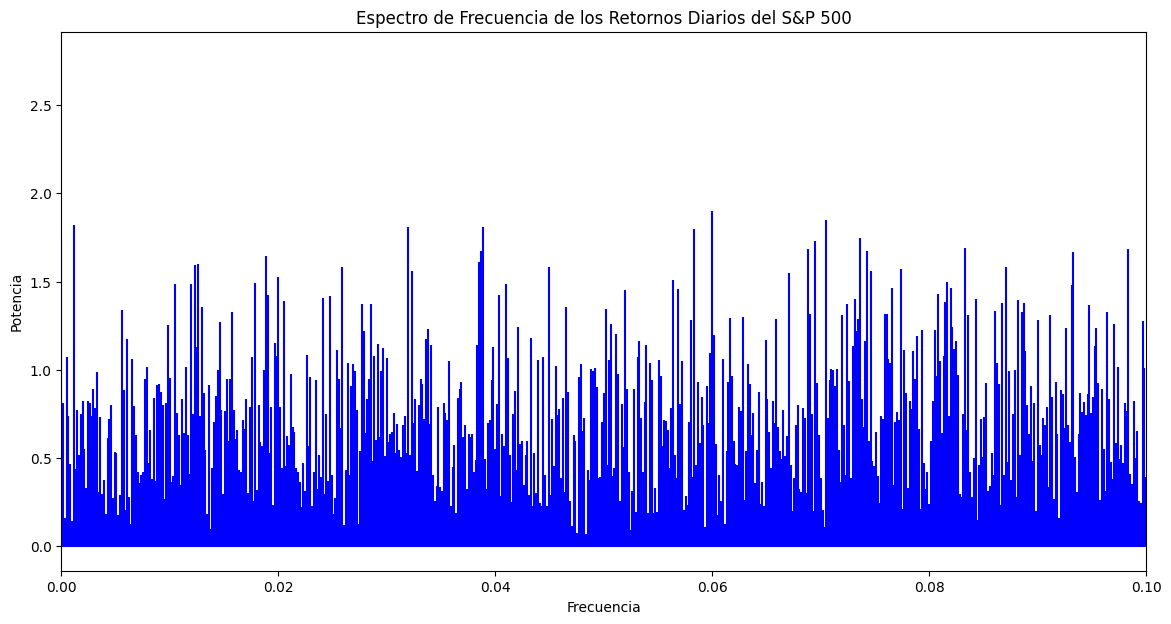

In [84]:


# Asumiendo que sp500_ARIMA es tu DataFrame y 'Close' es la columna con los precios de cierre
# Calcular los retornos diarios
retornos_diarios = sp500_ARIMA['Close'].pct_change().dropna().values

# Aplicar la Transformada de Fourier a los retornos diarios
fft_result = np.fft.fft(retornos_diarios)

# Obtener las frecuencias asociadas
frecuencias = np.fft.fftfreq(retornos_diarios.size, d=1)  # 'd=1' si los datos son diarios

# Calcular la potencia de la señal (magnitud del FFT)
potencia = np.abs(fft_result)

# Visualizar el Espectro de Frecuencia
plt.figure(figsize=(14, 7))
plt.stem(frecuencias, potencia, 'b', markerfmt=" ", basefmt="-b")
plt.xlim(0, 0.1)  # Ajusta este rango para enfocarte en las frecuencias bajas y ver mejor los picos
plt.title('Espectro de Frecuencia de los Retornos Diarios del S&P 500')
plt.xlabel('Frecuencia')
plt.ylabel('Potencia')
plt.show()


Ausencia de Picos Distintos: No hay picos destacados que sobresalgan significativamente por encima de los demás, lo que sugiere que no hay una estacionalidad clara y fuerte en los retornos diarios del S&P 500. Esto es común en los datos financieros, donde los retornos diarios están influenciados por una multitud de factores impredecibles y a menudo no presentan patrones estacionales claros.

Ruido a lo largo de las Frecuencias: La presencia de fluctuaciones a lo largo de todas las frecuencias con una magnitud relativamente estable podría ser indicativa de la naturaleza aleatoria o del "ruido blanco" en los retornos diarios.

Variabilidad Aleatoria: El hecho de que no haya picos claramente definidos podría indicar que los retornos diarios son en gran parte aleatorios y no están dominados por ciclos estacionales regulares.

Para concluir, la falta de patrones claros en este espectro de frecuencia sugiere que los retornos diarios del S&P 500 desde el año 2000 no están fuertemente influenciados por la estacionalidad a nivel diario. Esto no excluye la posibilidad de que existan tendencias o patrones en escalas de tiempo más largas, o que eventos específicos puedan causar perturbaciones significativas en el mercado, pero estos no parecen manifestarse como estacionalidad regular en los retornos diarios.

In [22]:


# Dividir los datos en conjuntos de entrenamiento y prueba
train_size_arima1 = int(len(sp500_ARIMA) * 0.8)
train_arima1, test_arima1 = sp500_ARIMA['Close'][:train_size_arima1], sp500_ARIMA['Close'][train_size_arima1:]

# Ajustar el modelo AutoARIMA
model_returns_arima1 = auto_arima(train_arima1, seasonal=False, trace=True,
                                  error_action='ignore', suppress_warnings=True,
                                  stepwise=True)

# Guardar el modelo
pickle.dump(model_returns_arima1, open('ARIMA1_Close_best_model_returns.pkl', 'wb'))
print("Mejor modelo ARIMA1 guardado:")
print(model_returns_arima1.summary())

# Realizar predicciones en el conjunto de prueba sin actualizar el modelo con nuevos valores
predicted_values_arima1 = model_returns_arima1.predict(n_periods=len(test_arima1))

# Convertir la lista de predicciones a un array para cálculo de errores
predicted_values_array_arima1 = np.array(predicted_values_arima1)

# Evaluar el rendimiento del modelo en el conjunto de prueba
mse_test_arima1 = mean_squared_error(test_arima1, predicted_values_array_arima1)
rmse_test_arima1 = np.sqrt(mse_test_arima1)
mae_test_arima1 = mean_absolute_error(test_arima1, predicted_values_array_arima1)

print(f'ARIMA1 Test - MSE: {mse_test_arima1}, RMSE: {rmse_test_arima1}, MAE: {mae_test_arima1}')

# Crear y guardar DataFrame con resultados
test_df_arima1 = pd.DataFrame({'Fecha_ARIMA1': pd.to_datetime(sp500_ARIMA.index[train_size_arima1:]), 'Valor_Real_ARIMA1': test_arima1, 'Prediccion_ARIMA1': predicted_values_array_arima1})
test_df_arima1.to_csv('ARIMA1_test_vs_predicciones.csv', index=False)

valores_reales_df_arima1 = test_df_arima1[['Fecha_ARIMA1', 'Valor_Real_ARIMA1']]
valores_reales_df_arima1.to_csv('ARIMA1_valores_reales_test.csv', index=False)


Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.02 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=44659.557, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=43229.820, Time=0.29 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.95 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=44657.559, Time=0.03 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=42495.263, Time=0.24 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=42171.798, Time=0.64 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=42000.839, Time=0.82 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=41854.420, Time=1.08 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=4.76 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=3.08 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=41852.423, Time=0.47 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=41998.843, Time=0.38 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=1.82 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Ti

c:\Users\lgarn\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\lgarn\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


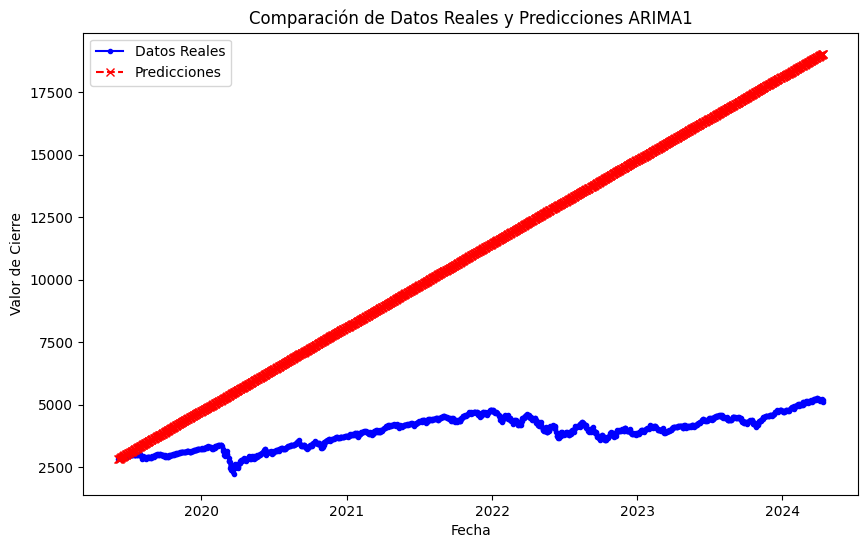

In [23]:

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(test_df_arima1['Fecha_ARIMA1'], test_df_arima1['Valor_Real_ARIMA1'], label='Datos Reales', marker='.', color='blue')
plt.plot(test_df_arima1['Fecha_ARIMA1'], test_df_arima1['Prediccion_ARIMA1'], label='Predicciones', marker='x', linestyle='--', color='red')
plt.title('Comparación de Datos Reales y Predicciones ARIMA1')
plt.xlabel('Fecha')
plt.ylabel('Valor de Cierre')
plt.legend()
plt.show()


ARIMA modificado para incluir los valores históricos que van ocurriendo conforme pasa el tiempo (replica la realidad de que a la hora de invertir sabes los datos reales del pasado)

In [24]:
# Asumiendo que sp500_ARIMA es tu DataFrame y ya está definido

# Dividir los datos en conjuntos de entrenamiento y prueba
train_size_arima2 = int(len(sp500_ARIMA) * 0.8)
train_arima2, test_arima2 = sp500_ARIMA['Close'][:train_size_arima2], sp500_ARIMA['Close'][train_size_arima2:]

# Ajustar el modelo AutoARIMA
model_returns_arima2 = auto_arima(train_arima2, seasonal=False, trace=True,
                                  error_action='ignore', suppress_warnings=True,
                                  stepwise=True)

# Guardar el modelo
pickle.dump(model_returns_arima2, open('ARIMA2_Close_best_model_returns.pkl', 'wb'))
print("Mejor modelo ARIMA2 guardado:")
print(model_returns_arima2.summary())

# Actualizar el modelo y realizar predicciones en el conjunto de prueba
predicted_values_arima2 = []  # Lista para almacenar las predicciones
for new_val in test_arima2:
    model_arima2 = pickle.load(open('ARIMA2_Close_best_model_returns.pkl', 'rb'))  # Cargar el modelo
    model_arima2.update(new_val)  # Actualizar el modelo con el último valor real
    pred_arima2 = model_arima2.predict(n_periods=1)[0]  # Realizar la predicción para el próximo día
    predicted_values_arima2.append(pred_arima2)  # Almacenar la predicción

# Convertir la lista de predicciones a un array para cálculo de errores
predicted_values_array_arima2 = np.array(predicted_values_arima2)

# Evaluar el rendimiento del modelo en el conjunto de prueba
mse_test_arima2 = mean_squared_error(test_arima2, predicted_values_array_arima2)
rmse_test_arima2 = np.sqrt(mse_test_arima2)
mae_test_arima2 = mean_absolute_error(test_arima2, predicted_values_array_arima2)

print(f'ARIMA2 Test - MSE: {mse_test_arima2}, RMSE: {rmse_test_arima2}, MAE: {mae_test_arima2}')

# Crear y guardar DataFrames
test_df_arima2 = pd.DataFrame({'Fecha': pd.to_datetime(sp500_ARIMA.index[train_size_arima2:]), 'Valor_Real': test_arima2, 'Prediccion': predicted_values_array_arima2})
test_df_arima2.to_csv('ARIMA2_test_vs_predicciones.csv', index=False)

valores_reales_df_arima2 = test_df_arima2[['Fecha', 'Valor_Real']]
valores_reales_df_arima2.to_csv('ARIMA2_valores_reales_test.csv', index=False)


Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.92 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=44659.557, Time=0.05 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=43229.820, Time=0.25 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.90 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=44657.559, Time=0.05 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=42495.263, Time=0.24 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=42171.798, Time=0.61 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=42000.839, Time=0.84 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=41854.420, Time=1.11 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=4.85 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=3.18 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=41852.423, Time=0.46 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=41998.843, Time=0.37 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=1.73 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Ti

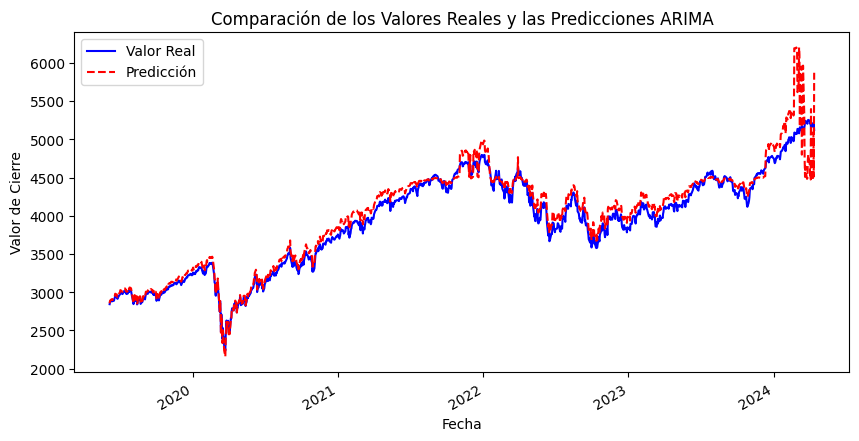

In [25]:
# Asegurándose de que 'Fecha' es el índice para facilitar la graficación
test_df_arima2.set_index('Fecha', inplace=True)

# Graficar los valores reales
plt.figure(figsize=(10, 5))
test_df_arima2['Valor_Real'].plot(label='Valor Real', color='blue')

# Graficar las predicciones
test_df_arima2['Prediccion'].plot(label='Predicción', color='red', linestyle='--')

# Agregar título y leyenda al gráfico
plt.title('Comparación de los Valores Reales y las Predicciones ARIMA')
plt.xlabel('Fecha')
plt.ylabel('Valor de Cierre')
plt.legend()

# Mostrar el gráfico
plt.show()


### IMPLEMENTACION PROPHET

In [40]:
SP500_Prophet = sp500['Close']
SP500_Prophet = sp500.reset_index()
SP500_Prophet = SP500_Prophet.rename(columns={'Date': 'ds', 'Close': 'y'})

23:15:34 - cmdstanpy - INFO - Chain [1] start processing
23:15:35 - cmdstanpy - INFO - Chain [1] done processing


Test - MSE: 325090.88668226666, RMSE: 570.167419870924, MAE: 450.87934655021724


c:\Users\lgarn\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\lgarn\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


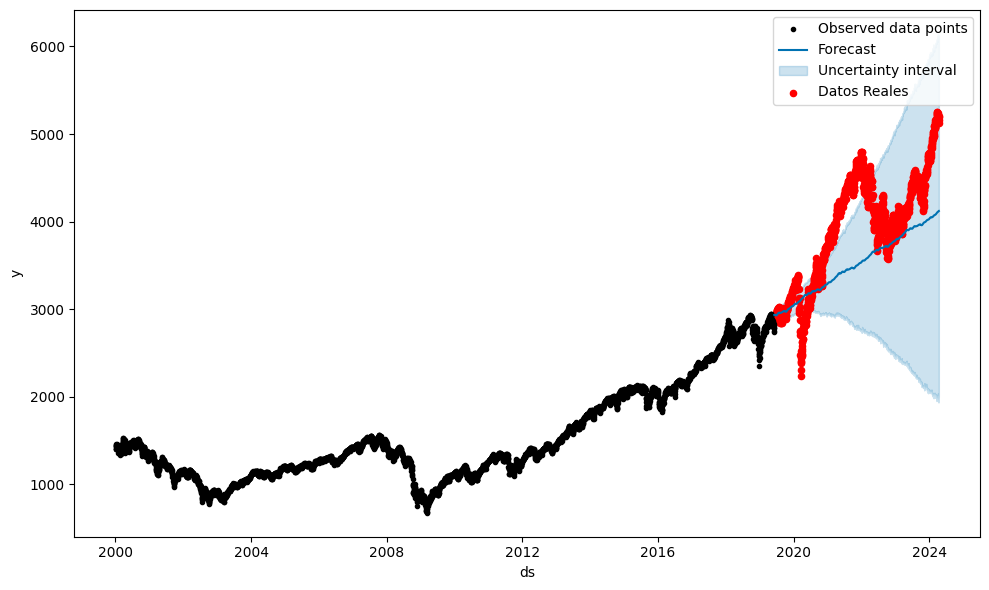

         dia  indice_real  indice_proyectado
0 2019-06-06  2843.489990        2934.216415
1 2019-06-07  2873.340088        2934.396402
2 2019-06-10  2886.729980        2935.758771
3 2019-06-11  2885.719971        2937.377173
4 2019-06-12  2879.840088        2936.903893


In [43]:
# Filtra los datos para incluir solo aquellos desde el año 2000 en adelante
SP500_Prophet = SP500_Prophet[SP500_Prophet['ds'].dt.year >= 2000]

# Asigna los valores de la columna 'Close' a una nueva columna 'y'
#SP500_Prophet['y'] = SP500_Prophet['Close']

# Dividir los datos en conjuntos de entrenamiento y prueba
train_size = int(len(SP500_Prophet) * 0.8)
train = SP500_Prophet.iloc[:train_size]
test = SP500_Prophet.iloc[train_size:]

# Ajustar el modelo Prophet
model = Prophet(daily_seasonality=True)
model.fit(train[['ds', 'y']])

# Crear DataFrame para predicciones futuras igual al tamaño del conjunto de prueba
future = test[['ds']]

# Realizar predicciones
forecast = model.predict(future)

# Evaluar el modelo comparando 'forecast' con 'test'
mse_test = mean_squared_error(test['y'], forecast['yhat'])
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(test['y'], forecast['yhat'])

print(f'Test - MSE: {mse_test}, RMSE: {rmse_test}, MAE: {mae_test}')

# Graficar resultados junto con los datos reales
fig = model.plot(forecast)
ax = fig.gca()
test.plot(kind='scatter', x='ds', y='y', color='red', ax=ax, label='Datos Reales')
ax.legend()

plt.show()

# Crear DataFrame con resultados solo para el período de prueba
resultados = pd.DataFrame({
    'dia': forecast['ds'],
    'indice_real': test['y'].reset_index(drop=True),
    'indice_proyectado': forecast['yhat']
})

# Mostrar los primeros resultados
print(resultados.head())


In [32]:
resultados.to_csv('resultados_prediccion_Prophet_sp500.csv', index=False)

Prophet incorporando valores reales diarios conforme van ocurriendo

22:02:22 - cmdstanpy - INFO - Chain [1] start processing
22:02:24 - cmdstanpy - INFO - Chain [1] done processing
22:02:24 - cmdstanpy - INFO - Chain [1] start processing
22:02:25 - cmdstanpy - INFO - Chain [1] done processing
22:02:26 - cmdstanpy - INFO - Chain [1] start processing
22:02:28 - cmdstanpy - INFO - Chain [1] done processing
22:02:28 - cmdstanpy - INFO - Chain [1] start processing
22:02:30 - cmdstanpy - INFO - Chain [1] done processing
22:02:30 - cmdstanpy - INFO - Chain [1] start processing
22:02:31 - cmdstanpy - INFO - Chain [1] done processing
22:02:32 - cmdstanpy - INFO - Chain [1] start processing
22:02:33 - cmdstanpy - INFO - Chain [1] done processing
22:02:33 - cmdstanpy - INFO - Chain [1] start processing
22:02:35 - cmdstanpy - INFO - Chain [1] done processing
22:02:35 - cmdstanpy - INFO - Chain [1] start processing
22:02:36 - cmdstanpy - INFO - Chain [1] done processing
22:02:37 - cmdstanpy - INFO - Chain [1] start processing
22:02:38 - cmdstanpy - INFO - Chain [1]

Test - MSE: 144112.1221622614, RMSE: 379.6210243944102, MAE: 313.6224903064263


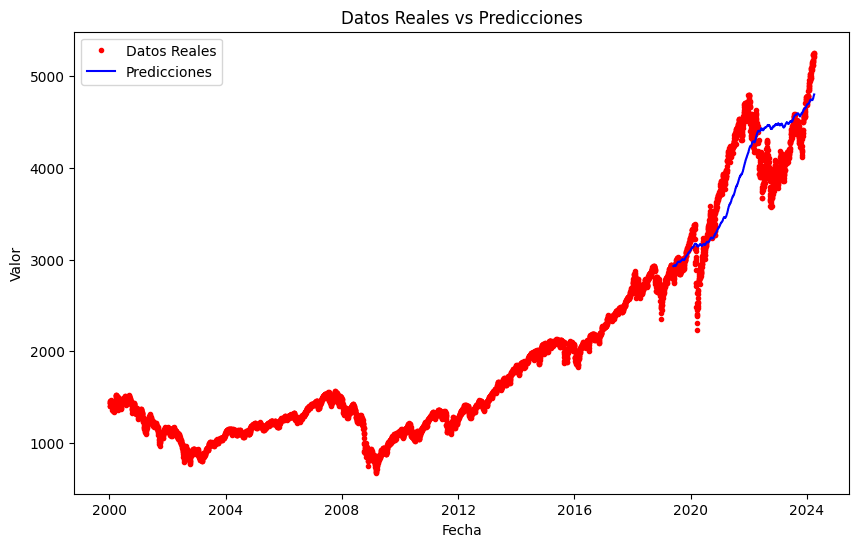

In [8]:




# Preparación del DataFrame SP500_Prophet
SP500_Prophet = sp500.iloc[:, [3]].reset_index()  # Asumiendo que la columna de interés está en la posición 3
SP500_Prophet['ds'] = pd.to_datetime(SP500_Prophet['Date'])
SP500_Prophet['ds'] = SP500_Prophet['ds'].dt.tz_localize(None)
SP500_Prophet = SP500_Prophet[SP500_Prophet['ds'].dt.year >= 2000]
SP500_Prophet['y'] = SP500_Prophet['Close']

# División en conjuntos de entrenamiento y prueba
train_size = int(len(SP500_Prophet) * 0.8)
train = SP500_Prophet.iloc[:train_size].copy()
test = SP500_Prophet.iloc[train_size:].copy()

predictions = []
dates_for_plot = []

for index, row in test.iterrows():
    # Crear un DataFrame para la próxima fecha
    future = pd.DataFrame([row['ds']], columns=['ds'])
    
    # Instanciar un nuevo modelo Prophet para cada iteración
    model = Prophet(daily_seasonality=False)
    model.fit(train[['ds', 'y']])
    
    # Realizar predicción para la próxima fecha
    forecast = model.predict(future)
    
    # Guardar la predicción
    predictions.append(forecast['yhat'].iloc[0])
    dates_for_plot.append(row['ds'])
    
    # Agregar la observación real al DataFrame de entrenamiento para el próximo reentrenamiento
    train = pd.concat([train, pd.DataFrame([row]).reset_index(drop=True)], ignore_index=True)

# Añadir predicciones al DataFrame de test para comparación
test['predictions'] = predictions

# Cálculo de métricas de error basadas en las predicciones actualizadas
mse_test = mean_squared_error(test['y'], test['predictions'])
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(test['y'], test['predictions'])

print(f'Test - MSE: {mse_test}, RMSE: {rmse_test}, MAE: {mae_test}')

# Graficar los datos reales de todo el período y las predicciones
plt.figure(figsize=(10, 6))
plt.plot(SP500_Prophet['ds'], SP500_Prophet['y'], 'r.', label='Datos Reales')
plt.plot(dates_for_plot, predictions, 'b-', label='Predicciones')
plt.legend()
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Datos Reales vs Predicciones')
plt.show()




In [9]:
# Guardar el DataFrame 'test' en un archivo CSV
test.to_csv('test_predictions.csv', index=False)